## Handling Missingness in The UK Biobank Metabolomics Dataset

Prior to this step, we performed correction on technical variation using the ukbnmr R package: https://cran.r-project.org/web/packages/ukbnmr/vignettes/ukbnmr.html. The final output of this process will be imputed using QRILC method in R.

### Preparation and initial checking

In [1]:
# Install scikit-learn
!pip install scikit-learn missingno

In [2]:
%%bash
dx download "ukbnmroutput_biomarker_data.csv" "ukbnmroutput_biomarker_qc_flags.csv" "ukbnmroutput_sample_qc_flags.csv" "metabolomics_dataset.tsv" "UKB Metabolomics:/agarham/biomarker_bridge.csv"

In [3]:
import pandas as pd
import numpy as np

# Load the original metabolomics dataset
biomarker_orig = pd.read_csv('metabolomics_dataset.tsv', sep = '\t')

# Import data containing the data fields, metabolite name, abbreviations (to be used as column names), and categories of the metabolites 
met_info = pd.read_csv('biomarker_bridge.csv', sep = ';')

# Create a list of metabolite columns to be selected from the dataframe, only containing the initial visit data
met_cols = [f'{met}-0.0' for met in met_info['ukb_field']] # This turns all the data fields into the initial visit format, e.g. '23475' into 'f.23475.0.0'

# Create a list of column names from the abbreviations
met_names = met_info['biomarker_hunt']

# Create a dictionary to pair the old column names with the new column names
met_cols_map = dict(zip(met_cols, met_names))

# Select and rename the columns
biomarker_orig = biomarker_orig[['eid'] + met_cols]
biomarker_orig = biomarker_orig.rename(columns=met_cols_map)

In [4]:
# Load the ukbnmr output datasets
biomarker = pd.read_csv('ukbnmroutput_biomarker_data.csv')
biomarker_qc = pd.read_csv('ukbnmroutput_biomarker_qc_flags.csv', low_memory=False)
sample_qc = pd.read_csv('ukbnmroutput_sample_qc_flags.csv')

# Check the datasets
print('biomarker_orig shape:')
print(biomarker_orig.shape)

print('biomarker shape:')
print(biomarker.shape)

print('biomarker qc shape:')
print(biomarker_qc.shape)

print('sample qc shape:')
print(sample_qc.shape)

print('eid in the original covers all eids in corrected biomarker df?')
print(biomarker['eid'].isin(biomarker_orig['eid']).all())

print('same set and order of eid in the corrected vs qc df?')
print(biomarker['eid'].tolist() == biomarker_qc['eid'].tolist())

biomarker_orig shape:
(501966, 250)
biomarker shape:
(274144, 329)
biomarker qc shape:
(274144, 329)
sample qc shape:
(274148, 22)
eid in the original covers all eids in corrected biomarker df?
True
same set and order of eid in the corrected vs qc df?
True


The ukbnmr output contains more derived metabolic measure, more than Nightingale's default markers. We want to remove the others as these also create some problematic numbers, e.g. inf.

In [5]:
# Get column intersection
common_cols = biomarker_orig.columns.intersection(biomarker.columns)

# Select only those columnn
biomarker = biomarker[common_cols]
biomarker_qc = biomarker_qc[common_cols]

# Check results
print('biomarker shape:')
print(biomarker.shape)

print('biomarker qc shape:')
print(biomarker_qc.shape)

biomarker shape:
(274144, 250)
biomarker qc shape:
(274144, 250)


Before performing pre-processing, we check the output of ukbnmr (corrected for technical variation) vs the original metabolomics dataset.

In [6]:
# # Check the range of the original metabolomics dataset
# ranges_orig = pd.DataFrame({
#     'min': biomarker_orig.min(),
#     'max': biomarker_orig.max()
# })

# ranges_orig.index.name = 'metabolite'
# ranges_orig.reset_index(inplace=True)

# ranges_sorted_orig = ranges_orig.sort_values(by='max', ascending=False).sort_index()

# # Check the range of the corrected metabolomics dataset
# ranges = pd.DataFrame({
#     'min': biomarker.min(),
#     'max': biomarker.max()
# })

# ranges.index.name = 'metabolite'
# ranges.reset_index(inplace=True)

# ranges_sorted = ranges.sort_values(by='max', ascending=False).sort_index()

# # Compare the two
# orig_vs_corr = pd.merge(ranges_sorted_orig, ranges_sorted, on='metabolite', suffixes=('_orig', '_corr'))
# orig_vs_corr['min_shift'] = orig_vs_corr['min_corr'] - orig_vs_corr['min_orig']
# orig_vs_corr['max_shift'] = orig_vs_corr['max_corr'] - orig_vs_corr['max_orig']

# orig_vs_corr.to_csv('range_original_vs_corrected_metabolites.csv', index = False)

In [7]:
# %%bash
# dx upload "range_original_vs_corrected_metabolites.csv"

In [8]:
# # Visualize the comparison between the original and corrected metabolites
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

# # Constants
# N_COLS_PER_PAGE = 4  # Number of plots horizontal
# N_ROWS_PER_PAGE = 3  # Number of plots vertical
# PLOTS_PER_PAGE = N_COLS_PER_PAGE * N_ROWS_PER_PAGE

# # Remove eid column (first column)
# df1_data = biomarker_orig.iloc[:, 1:]
# df2_data = biomarker.iloc[:, 1:]

# # Get shared columns (in case of mismatch)
# columns = df1_data.columns.intersection(df2_data.columns)

# # Set up PDF
# with PdfPages("boxplot_original_vs_corrected_metabolites.pdf") as pdf:
#     for i in range(0, len(columns), PLOTS_PER_PAGE):
#         cols_batch = columns[i:i + PLOTS_PER_PAGE]
        
#         fig, axes = plt.subplots(N_ROWS_PER_PAGE, N_COLS_PER_PAGE, figsize=(8.27, 11.69))  # A4 size in inches
#         axes = axes.flatten()

#         for j, col in enumerate(cols_batch):
#             ax = axes[j]
#             ax.boxplot(
#                 [df1_data[col].dropna(), df2_data[col].dropna()],
#                 labels=['orig', 'corr'],
#                 patch_artist=True
#             )
#             ax.set_title(col, fontsize=8)
        
#         # Hide unused axes if last page has fewer plots
#         for j in range(len(cols_batch), len(axes)):
#             axes[j].axis('off')

#         plt.tight_layout()
#         pdf.savefig(fig)
#         plt.close(fig)

In [9]:
# %%bash
# dx upload "boxplot_original_vs_corrected_metabolites.pdf"

### Remove samples with potential dilution and missing values >10%

In [10]:
# Check the sample qc flag with potential dilution: Low Protein

print('Number of low protein flags:')
print(sample_qc['Low.Protein'].value_counts())

Number of low protein flags:
Yes    1781
Name: Low.Protein, dtype: int64


In [11]:
# Find rows with >10% NaN or 0 (excluding first column: 'eid')
biomarker_only = biomarker.iloc[:, 1:]
num_columns = biomarker_only.shape[1]
threshold = int(num_columns * 0.1)

mask = biomarker_only.isna() | (biomarker_only == 0)
rows_manynanzero = mask.sum(axis=1) > threshold
eids_manynanzero = biomarker.loc[rows_manynanzero, 'eid']

# Get the low protein flagged eids from the sample qc flag dataset
eids_lowprot = sample_qc.loc[sample_qc['Low.Protein'] == 'Yes', 'eid']

# Combine both sets of eids to drop
eids_to_drop = pd.concat([eids_manynanzero, eids_lowprot]).unique()

# Drop those rows from the biomarker and biomarker qc dataframes
cleaned_biomarker = biomarker[~biomarker['eid'].isin(eids_to_drop)]
cleaned_biomarker_qc = biomarker_qc[~biomarker_qc['eid'].isin(eids_to_drop)]

# Check results
print('Number of rows with >10% NaN or 0:', len(eids_manynanzero))
print('% of rows with >10% NaN or 0:', len(eids_manynanzero)/len(biomarker)*100)
print('Number of rows with low protein flag:', len(eids_lowprot))
print('% of rows with low protein flag:', len(eids_lowprot)/len(biomarker)*100)
print('Number of rows to drop:', len(eids_to_drop))
print('% of rows to drop:', len(eids_to_drop)/len(biomarker)*100)

print('\nCleaned biomarker dataset:')
print(cleaned_biomarker.shape)
print('\nCleaned biomarker qc dataset:')
print(cleaned_biomarker_qc.shape)

Number of rows with >10% NaN or 0: 4394
% of rows with >10% NaN or 0: 1.6028072837632776
Number of rows with low protein flag: 1781
% of rows with low protein flag: 0.649658573596358
Number of rows to drop: 6096
% of rows to drop: 2.223648885257383

Cleaned biomarker dataset:
(268048, 250)

Cleaned biomarker qc dataset:
(268048, 250)


### Impute biomarkers based on the biomarker QC flags
For LoQ flagged and non-flagged missing values assume Missing Not At Random (MNAR), then impute with QRILC method. For other flags, impute with kNN). Here, we perform the kNN imputation only.

In [12]:
# Slice the biomarker dataset excluding 'eid' column
to_impute = cleaned_biomarker.iloc[:, 1:].copy()
flags = cleaned_biomarker_qc.iloc[:, 1:].copy()

In [13]:
# # For trial, we subset to_impute dataset to 10% of the original size
# cleaned_biomarker_subset = cleaned_biomarker.sample(frac=0.1, replace=False, random_state=1)
# to_impute_subset = cleaned_biomarker_subset.iloc[:, 1:].copy()

<AxesSubplot: >

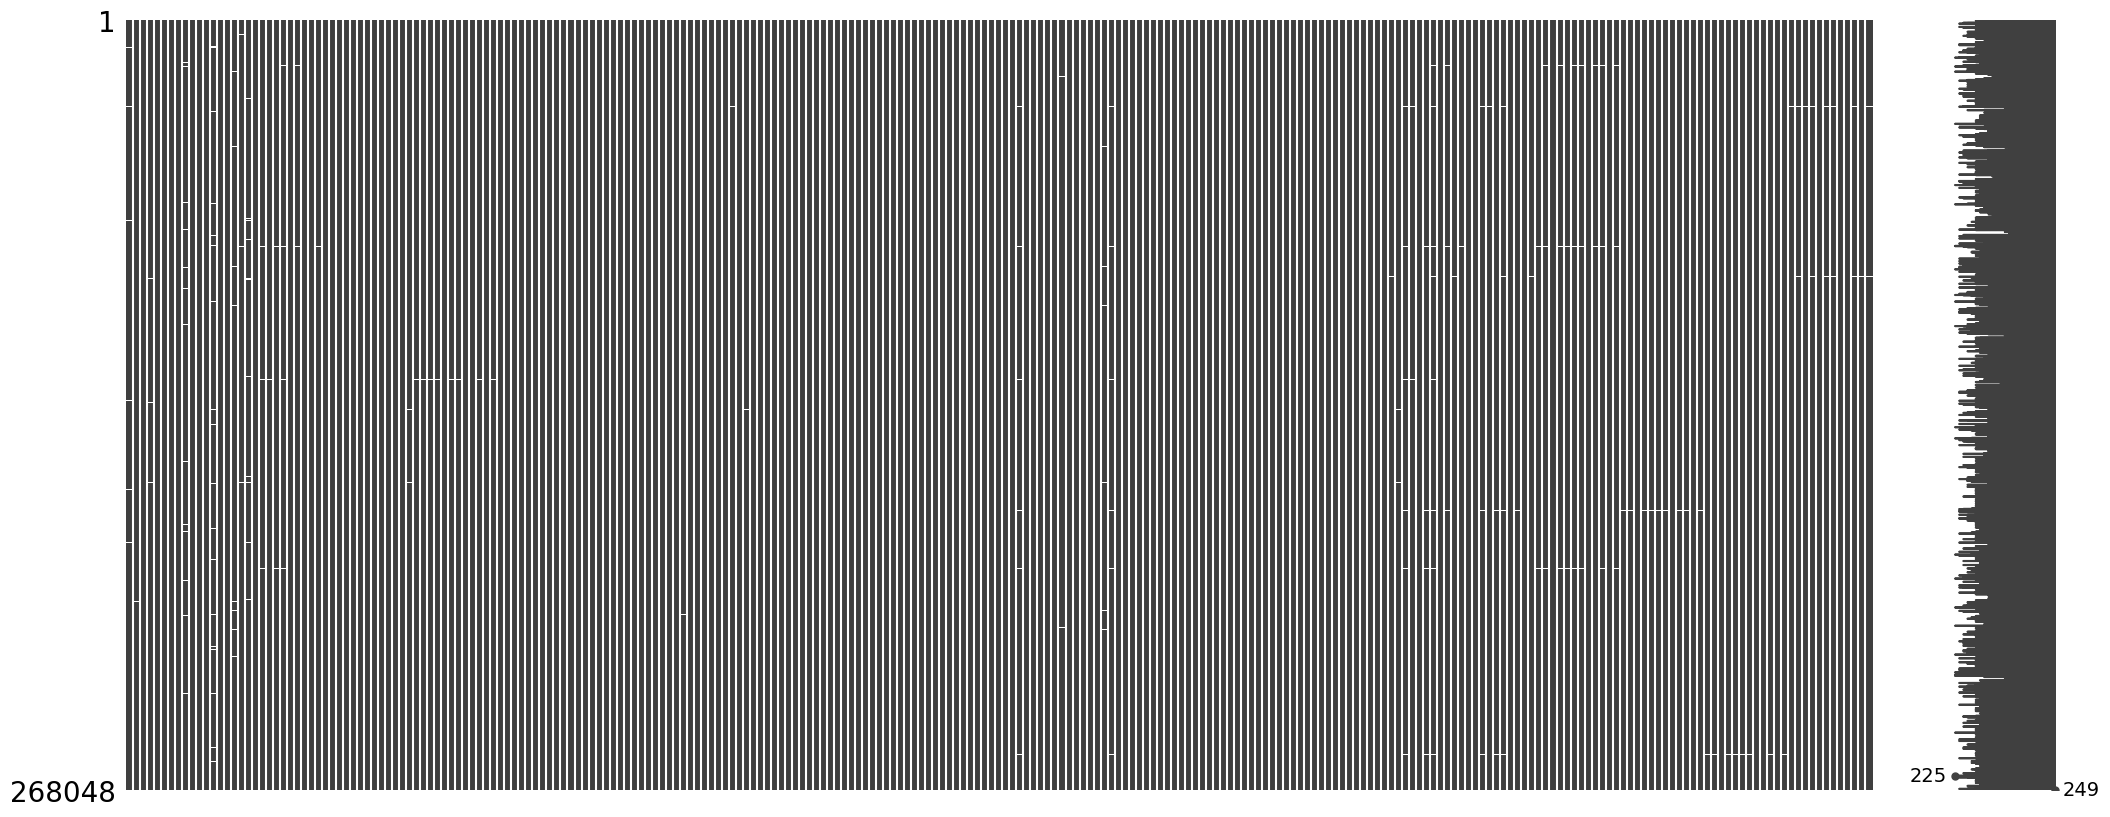

In [14]:
# Visualize dataset before imputation
import missingno as msno

msno.matrix(to_impute)

In [15]:
#Apply kNN imputation
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(to_impute)
knn_imputed_biomarker = pd.DataFrame(imputed_array, columns=to_impute.columns, index=to_impute.index)

In [16]:
# # Save the output
# knn_imputed_biomarker.insert(0, 'eid', cleaned_biomarker['eid']) 
# knn_imputed_biomarker.to_csv('all_knn_imputed_biomarker_v2.csv', index = True)

In [17]:
# %%bash
# dx upload "all_knn_imputed_biomarker_v2.csv"

to_impute shape:
(268048, 249)
flags shape:
(268048, 249)
knn_imputed_biomarker shape:
(268048, 249)


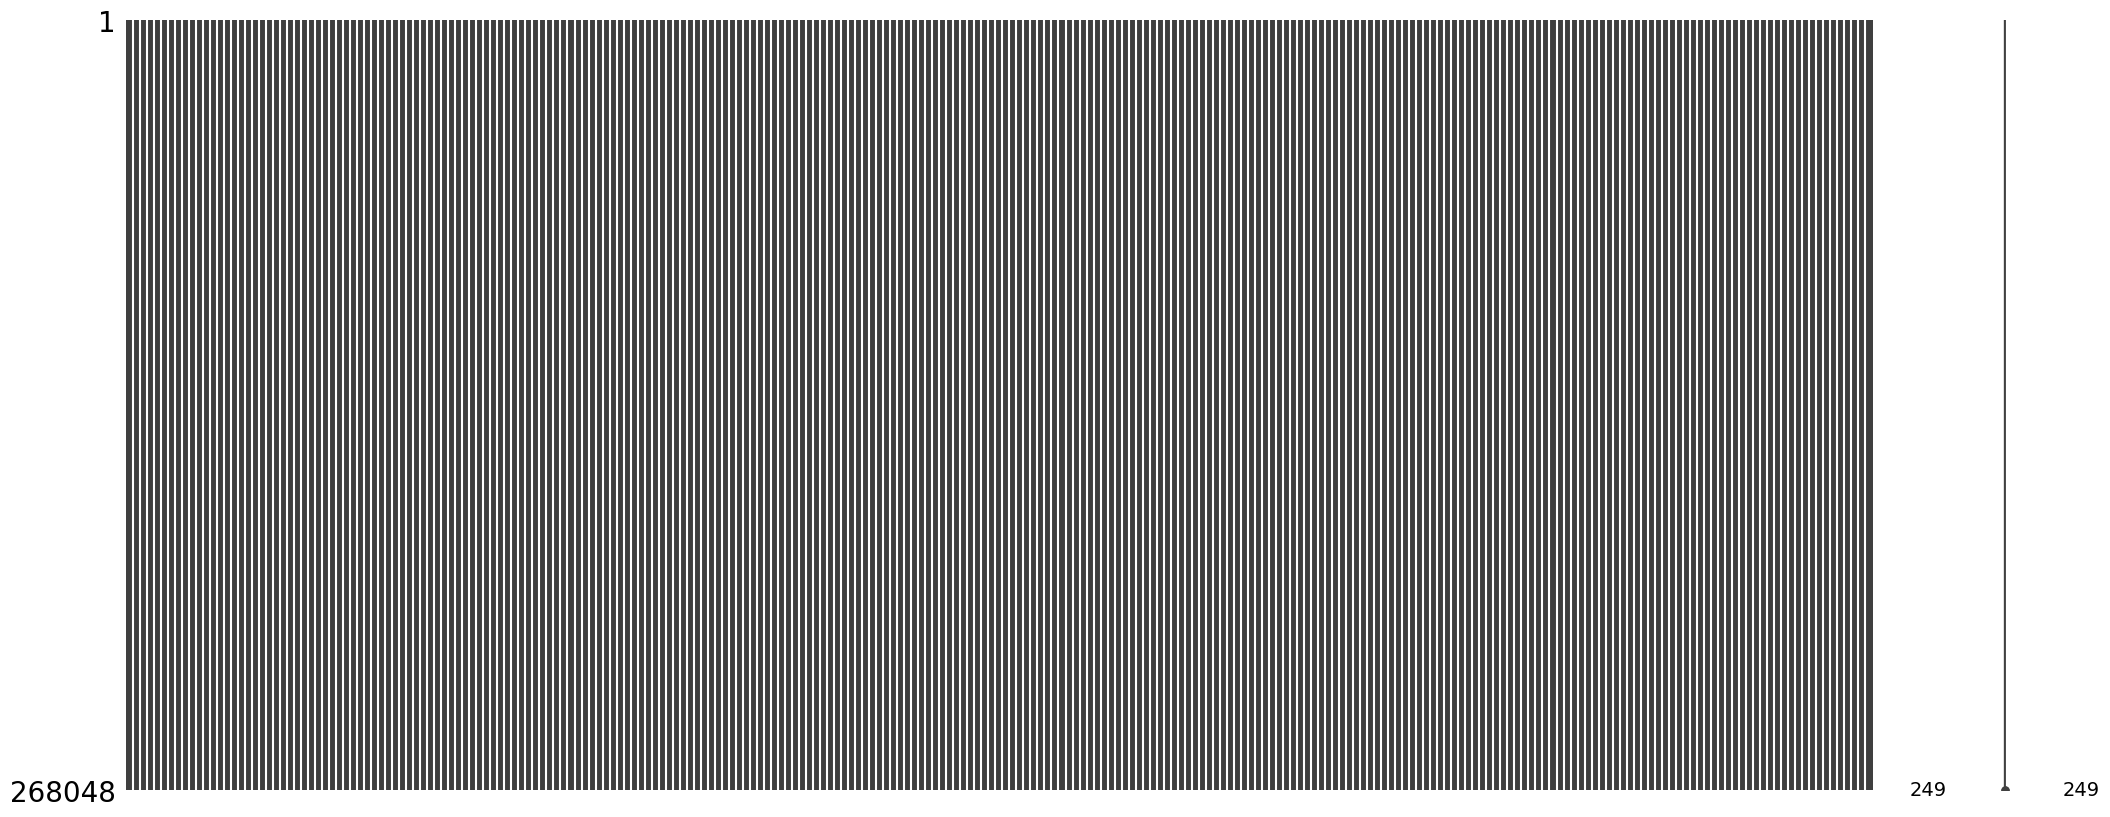

In [18]:
# Visualize dataset after imputation
msno.matrix(knn_imputed_biomarker)

# Check shapes
print('to_impute shape:')
print(to_impute.shape)

print('flags shape:')
print(flags.shape)

print('knn_imputed_biomarker shape:')
print(knn_imputed_biomarker.shape)

In [19]:
# %%bash
# dx download "all_knn_imputed_biomarker_v2.csv"

In [20]:
# # Load the pre saved dataset
# knn_imputed_biomarker = pd.read_csv('all_knn_imputed_biomarker_v2.csv')

In [21]:
# Create mask of missing values in the biomarker dataset
mask_nan = to_impute.isna()

# Create mask of NOT missing flag in the qc dataset
mask_flag = flags.notna()

# Create mask for flags NOT containing 'Below limit of quantification' (case insensitive)
mask_non_loq = ~flags.astype(str).applymap(
    lambda x: 'below limit of quantification' in x.lower()
)

# Count number of NaNs
all_nan_count = mask_nan.sum().sum()

# Count flagged NaNs
flagged_nan_count = (mask_nan & mask_flag).sum().sum()
pct_flagged_nan = (flagged_nan_count/all_nan_count)*100

non_flagged_nan_count = (mask_nan & ~mask_flag).sum().sum()
pct_non_flagged_nan = (non_flagged_nan_count/all_nan_count)*100

# Count LoQ flags
loq_count = (mask_nan & mask_flag & ~mask_non_loq).sum().sum()
pct_loq = (loq_count/flagged_nan_count)*100

non_loq_count = (mask_nan & mask_flag & mask_non_loq).sum().sum()
pct_non_loq = (non_loq_count/flagged_nan_count)*100

print(f'Number of NaNs: {all_nan_count}')

print(f'Number of flagged NaNs: {flagged_nan_count}')
print(f'Percentage of flagged NaNs of total NaNs: {pct_flagged_nan}')

print(f'Number of non-flagged NaNs: {non_flagged_nan_count}')
print(f'Percentage of non-flagged NaNs of total NaNs: {pct_non_flagged_nan}')

print(f'Number of LoQ flags: {loq_count}')
print(f'Percentage of LoQ flags of total flags: {pct_loq}')

print(f'Number of non-LoQ flags: {non_loq_count}')
print(f'Percentage of LoQ flags of total flags: {pct_non_loq}')

Number of NaNs: 63905
Number of flagged NaNs: 59957
Percentage of flagged NaNs of total NaNs: 93.82207964947969
Number of non-flagged NaNs: 3948
Percentage of non-flagged NaNs of total NaNs: 6.177920350520304
Number of LoQ flags: 11762
Percentage of LoQ flags of total flags: 19.61739246459963
Number of non-LoQ flags: 48195
Percentage of LoQ flags of total flags: 80.38260753540037


The biomarker_qc output from the ukbnmr package combines QC flags for derived biomarkers from those of their parent marker, e.g. XXL_VLDL_CE_pct combines flags from XXL_VLDL_CE, XXL_VLDL_PL, and XXL_VLDL_FC. As a result, it gives more flags than the original dataset. This leads to most metabolites being flagged, with only about 6% remaining unflagged.

knn_imputed_biomarker_final shape:
(268048, 250)
match eid on the final dataset vs the cleaned dataset:
True
number of missingness BEFORE imputation:
63905
number of missingness AFTER imputation (kNN only):
15710


<AxesSubplot: >

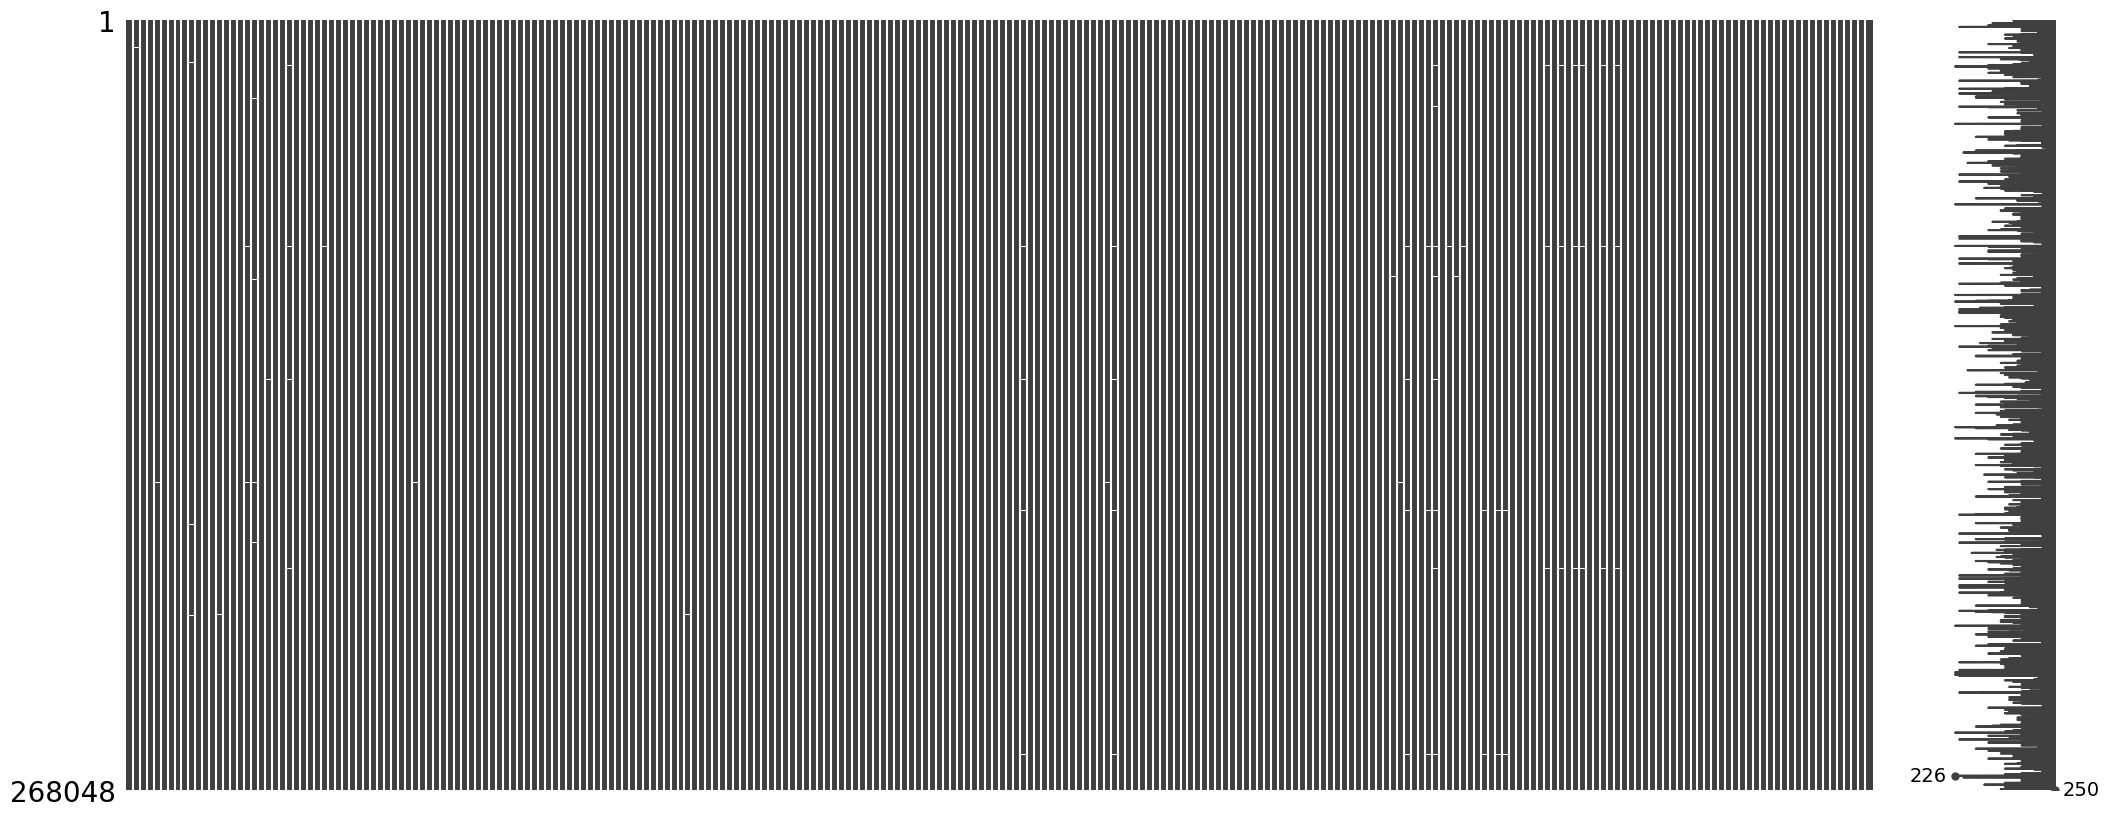

In [22]:
# Mask for cells to impute = missing & flag not LoQ
mask_impute = mask_nan & mask_flag & mask_non_loq

# Restore original NaNs for values we didn't want to impute (those LoQ flagged and not flagged)
knn_imputed_biomarker_final = to_impute.copy()
knn_imputed_biomarker_final.values[mask_impute.values] = knn_imputed_biomarker.values[mask_impute.values]

# Add back eid column
knn_imputed_biomarker_final.insert(0, 'eid', cleaned_biomarker['eid'])

# Save the output
knn_imputed_biomarker.to_csv('all_knn_imputed_biomarker_v2.csv', index = True)
knn_imputed_biomarker_final.to_csv('knn_imputed_metabolomics_v2.csv', index = False)

# Check results
print('knn_imputed_biomarker_final shape:')
print(knn_imputed_biomarker_final.shape)

print('match eid on the final dataset vs the cleaned dataset:')
print(set(cleaned_biomarker['eid']) == set(knn_imputed_biomarker_final['eid']))

print('number of missingness BEFORE imputation:')
print(to_impute.isna().sum().sum())

print('number of missingness AFTER imputation (kNN only):')
print(knn_imputed_biomarker_final.isna().sum().sum())

# Visualize the final dataset
msno.matrix(knn_imputed_biomarker_final)

In [23]:
%%bash
dx upload "knn_imputed_metabolomics_v2.csv" "all_knn_imputed_biomarker_v2.csv"

ID                                file-J1jK8B0JZ8jY31vgKbYBjf61
Class                             file
Project                           project-J0yb91QJZ8jZ9ppFk6zGQgGp
Folder                            /
Name                              knn_imputed_metabolomics_v2.csv
State                             closing
Visibility                        visible
Types                             -
Properties                        -
Tags                              -
Outgoing links                    -
Created                           Fri Jul 11 10:15:04 2025
Created by                        agarham
 via the job                      job-J1jGPvjJZ8jVBJz4Fxb1f59q
Last modified                     Fri Jul 11 10:15:08 2025
Media type                        
archivalState                     "live"
cloudAccount                      "cloudaccount-dnanexus"
ID                                file-J1jK8F0JZ8jQZjxzvg2B6vKF
Class                             file
Project                           projec

<AxesSubplot: >

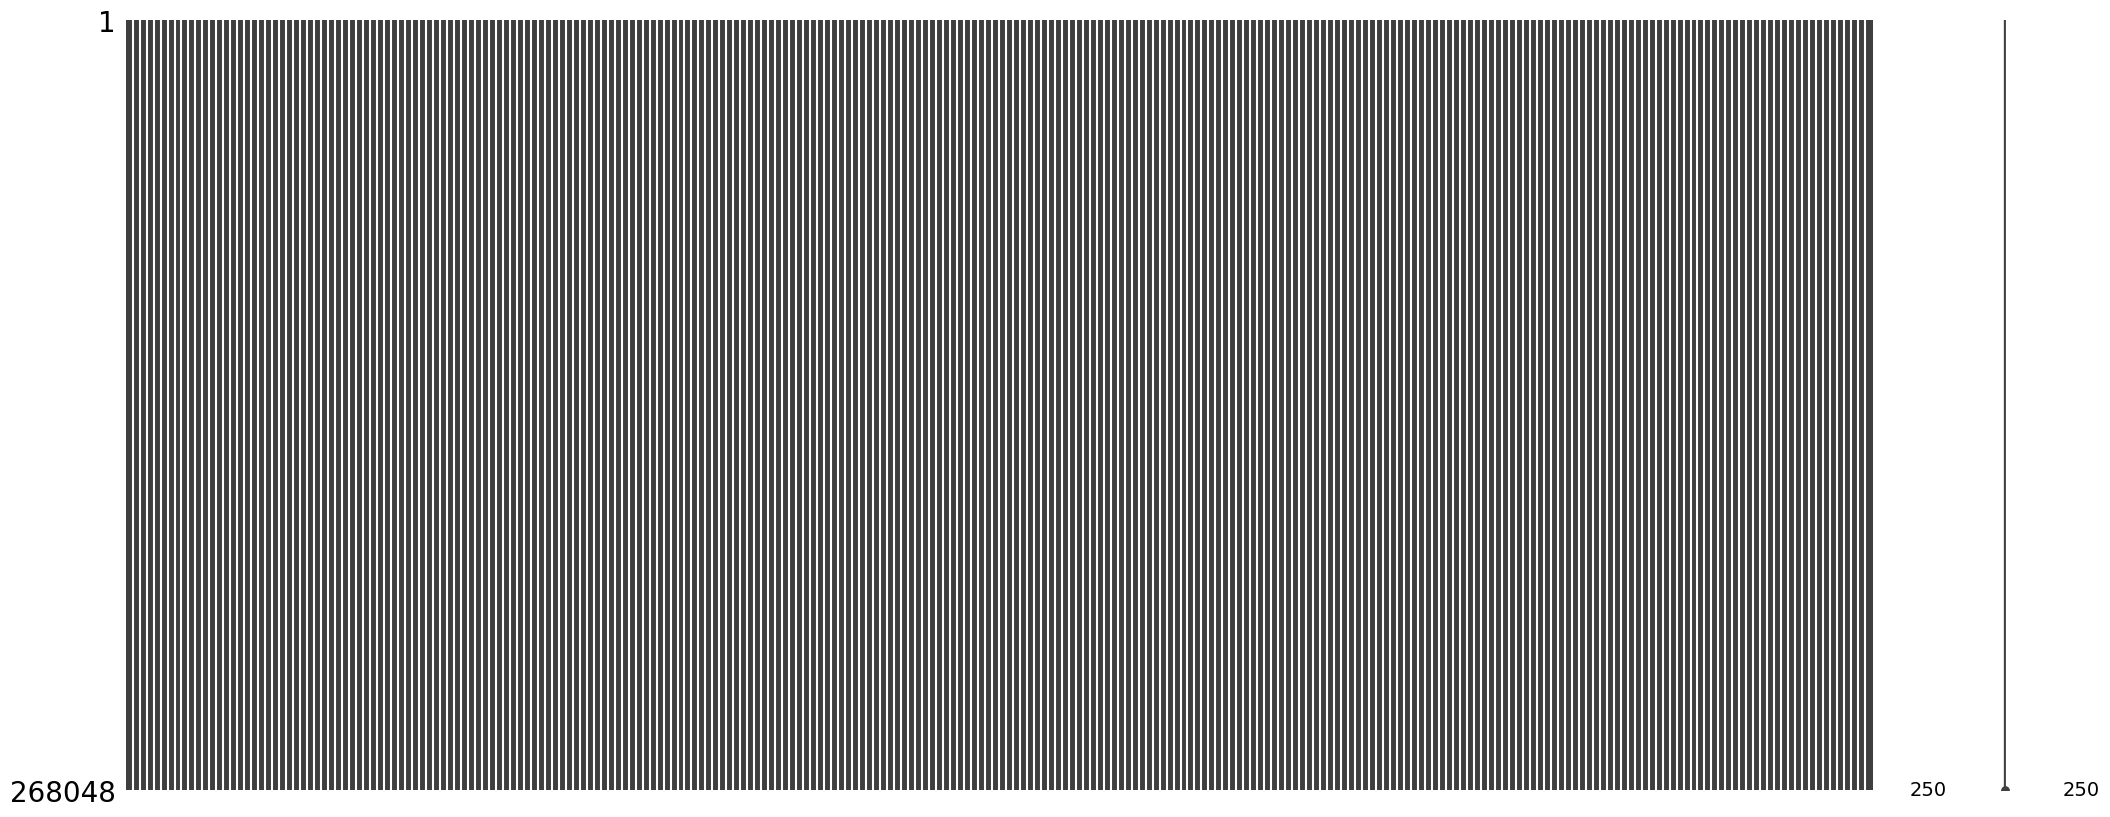

In [24]:
# Check QRILC imputation results
qrilc_imputed_biomarker = pd.read_csv('qrilc_imputed_metabolomics_v2.csv')

msno.matrix(qrilc_imputed_biomarker)